In [1]:
from src.common import *
from src.Ballistic import *

## Ballistic annihilation

We are first describing trajectories in a purely mechanical way, as a set of positions function of time $x_i(t)$. Each particle has an uniform velocity $v$, which we randomly draw from the set $\{-v_0, 0, v_0\}$, and the particles positions are bound within a periodic boundary of size $L$. When two particles meet, they will either scatter off each other elastically (if they are of the same kind) or annihilate each other.

A simulation set is described with the class `Ballistic`, whose constructor takes a number of particles, an initial concentration, a box size, and a number of steps for the simulation. Particles are then placed evenly along the axis and given random velocities and random particle/anti-particle states. After that, the `compute()` method is called, which runs the simulation proper, comprised of the following steps:

1. Bounds checking: particles that have not been annihilated are bounds-checked and put back in the $[0, L]$ interval if they are outside it.
2. Collision checking: the distance between pairs of particles is computed at the given time step and the following one; if the sign of the distance has changed, the particles must have crossed paths, which means that they have collided. If the particles are of the same kind, they bounce off each other and their velocities are simply swapped; if they are of opposite kind, the two disappear.
3. All remaining particles are moved by `v*dt`, time advances one step and the loop repeats.

Once all the calculations are done, the trajectories are plotted as time-position lines, with blue representing particles and red representing anti-particles.

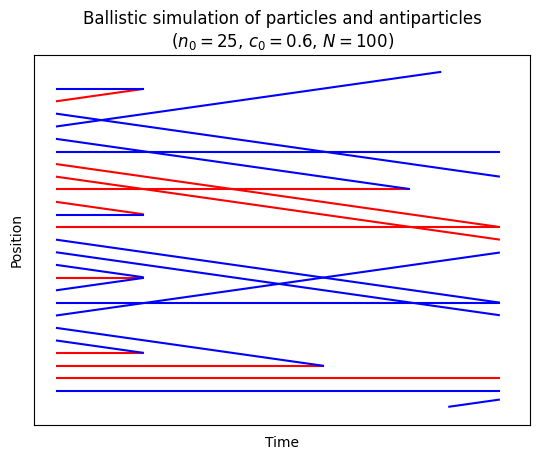

In [15]:
b = Ballistic(25, 0.6)
b.plot()

We can then calculate and plot the concentration of particles at each step of the simulation.

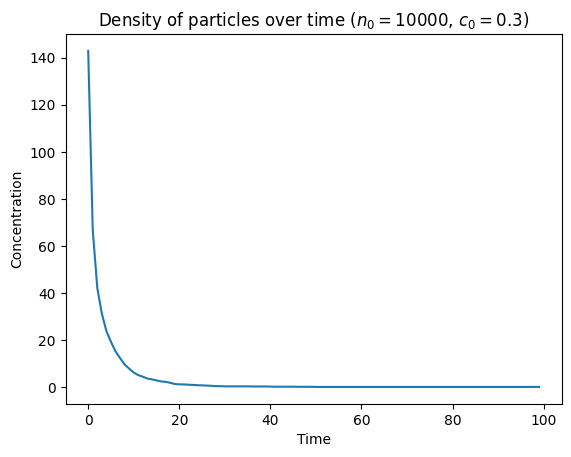

In [6]:
b = Ballistic(10000, 0.3)
c = concentration(b, plot=True)

/tmp/ipykernel_414/666286344.py:4: RuntimeWarning: invalid value encountered in power
  c_model = lambda t, a, b, c, d: a + b/(t + c)**d


Concentration fit a+b/(t+c)^d, with:
a = -0.6612806462229828, b = 307.0856930982321,
c = 1.6576733859071775, d = 1.5126344411671908
R^2 = 0.9982643047441059


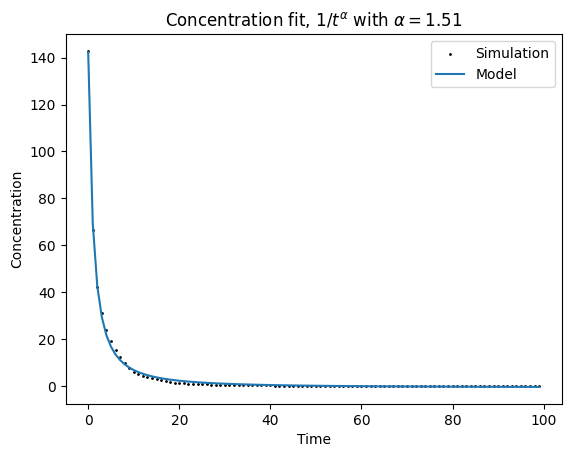

1.5126344411671908

In [10]:
fit(c)

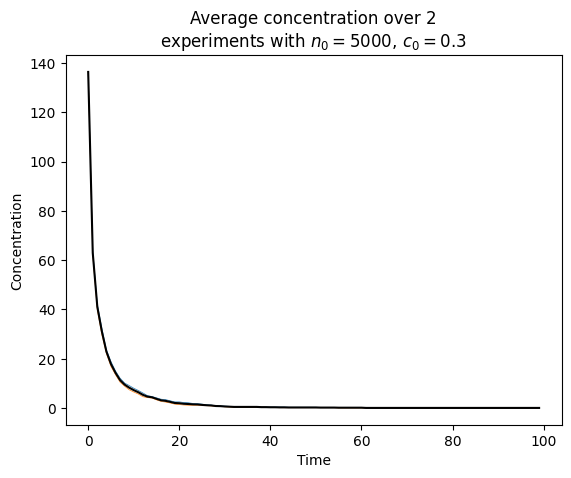

In [13]:
avg_c = avg_concentration(Ballistic, (5000, 0.3), 2)

/tmp/ipykernel_414/666286344.py:4: RuntimeWarning: invalid value encountered in power
  c_model = lambda t, a, b, c, d: a + b/(t + c)**d


Concentration fit a+b/(t+c)^d, with:
a = -0.8374651254283212, b = 225.1669674818271,
c = 1.4396946405212816, d = 1.368523162894375
R^2 = 0.998843372569625


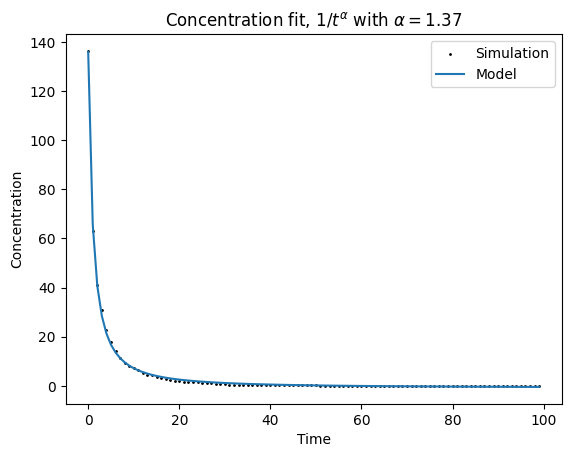

1.368523162894375

In [14]:
fit(avg_c)

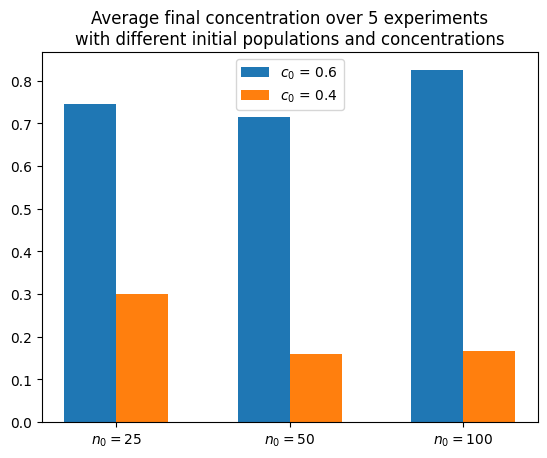

In [5]:
params = [(25, 50, 100), (0.6, 0.4)]
end_state(Ballistic, params, 5)